In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 31.0 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, Concatenate, Multiply, Layer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
import numpy as np
import rasterio
import cv2
import os

In [3]:
# Function to load and preprocess high-resolution images
def load_image(image_path, target_size=(1054, 1054), normalize=True):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file {image_path} does not exist.")
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"Failed to load image {image_path}.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_CUBIC)
    if normalize:
        image = image / 255.0  # Normalize to 0 to 1
    return image

# Function to create low-resolution images from high-resolution images
def create_lr_image(hr_image, downscale_size=(160, 160), upscale_size=(1054, 1054), normalize=True):
    lr_image = cv2.resize(hr_image, downscale_size, interpolation=cv2.INTER_CUBIC)
    lr_image = cv2.resize(lr_image, upscale_size, interpolation=cv2.INTER_CUBIC)
    if normalize:
        lr_image = np.clip(lr_image / 255.0, 0, 1)  # Normalize to 0 to 1 and clip values
    return lr_image

# Function to split images into patches
def split_image(image, size=(527, 527)):
    h, w = image.shape[:2]
    split_images = []
    for i in range(0, h, size[0]):
        for j in range(0, w, size[1]):
            split_img = image[i:i + size[0], j:j + size[1]]
            if split_img.shape[:2] == size:
                split_images.append(split_img)
    return split_images

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Generator class for training data with splitting
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_files, hr_dir, batch_size=16, target_size=(1054, 1054), patch_size=(527, 527)):
        self.image_files = image_files
        self.hr_dir = hr_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.patch_size = patch_size
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_files) * 4 / self.batch_size))  # 4 patches per image

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size//4:(index+1)*self.batch_size//4]
        lr_batch = []
        hr_batch = []
        for i in indices:
            hr_image_path = os.path.join(self.hr_dir, self.image_files[i])
            hr_image = load_image(hr_image_path, self.target_size, normalize=True)
            lr_image = create_lr_image(hr_image, downscale_size=(160, 160), upscale_size=self.target_size, normalize=True)
            hr_patches = split_image(hr_image, self.patch_size)
            lr_patches = split_image(lr_image, self.patch_size)
            lr_batch.extend(lr_patches)
            hr_batch.extend(hr_patches)
        return np.array(lr_batch, dtype=np.float32), np.array(hr_batch, dtype=np.float32)

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_files))
        np.random.shuffle(self.indices)

In [6]:
# Define PSNR and SSIM metrics
def psnr_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def create_model(input_shape=(527, 527, 3)):
    lr_input = Input(shape=input_shape, name='lr_input')

    x = Conv2D(64, (9, 9), activation='relu', padding='same')(lr_input)
    x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
    outputs = Conv2D(3, (5, 5), activation='linear', padding='same')(x)

    model = Model(inputs=lr_input, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', psnr_metric, ssim_metric])
    return model

In [7]:
model = create_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lr_input (InputLayer)                │ (None, 527, 527, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 527, 527, 64)        │          15,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 527, 527, 32)        │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 527, 527, 3)         │           2,403 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,099 (78.51 KB)

 Trainable params: 20,099 (78.51 KB)

 Non-trainable params: 0 (0.00 B)

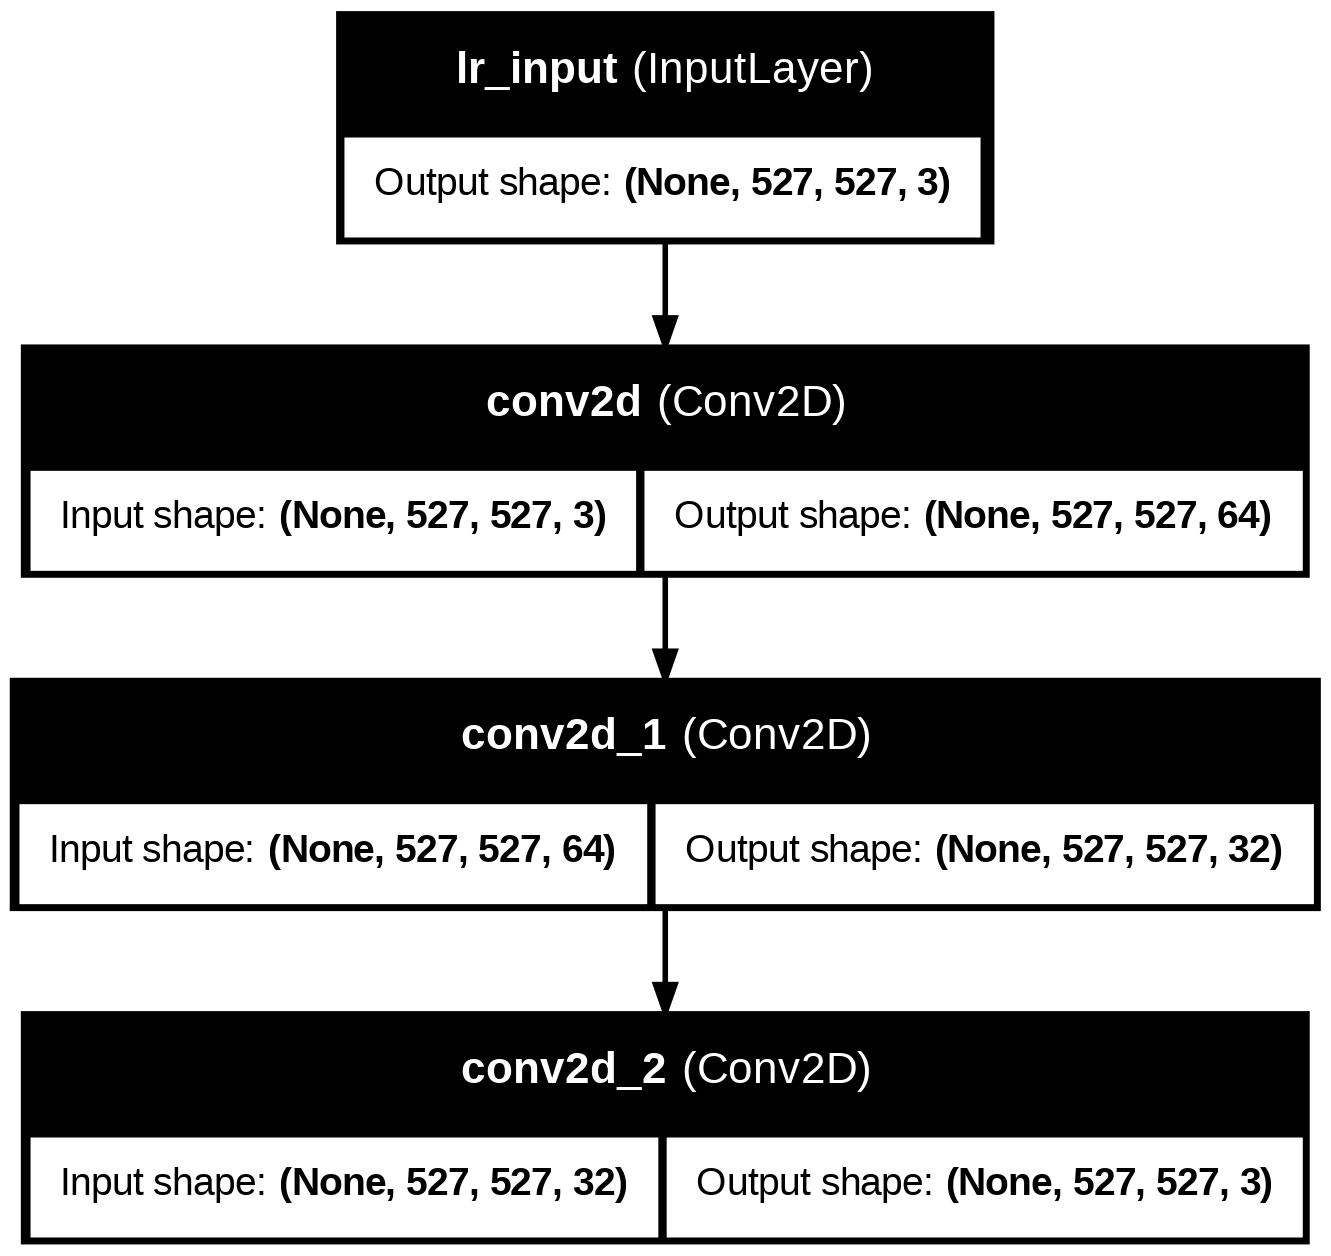

In [8]:
from tensorflow.keras.utils import plot_model

# Plot model
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

In [9]:
# Load image filenames
hr_image_files = [f for f in os.listdir('/content/drive/MyDrive/high_resolution_final') if f.endswith('_rgb.png') and not f.startswith('.')]

# Split the image filenames into training and testing sets
train_files, test_files = train_test_split(hr_image_files, test_size=0.2, random_state=42)

In [10]:
# Create data generators with the split data
train_generator = DataGenerator(train_files, hr_dir='/content/drive/MyDrive/high_resolution_final', batch_size=16)
test_generator = DataGenerator(test_files, hr_dir='/content/drive/MyDrive/high_resolution_final', batch_size=16)

In [11]:
# Check data function
def check_data(generator):
    lr_batch, hr_batch = next(iter(generator))
    for i in range(min(4, len(lr_batch))):
        print(f"Low-resolution patch {i}: shape={lr_batch[i].shape}, min={lr_batch[i].min()}, max={lr_batch[i].max()}")
        print(f"High-resolution patch {i}: shape={hr_batch[i].shape}, min={hr_batch[i].min()}, max={hr_batch[i].max()}")
        print("")

# Check the data
check_data(test_generator)

Low-resolution patch 0: shape=(527, 527, 3), min=0.0, max=0.004581969231367111
High-resolution patch 0: shape=(527, 527, 3), min=0.0, max=1.0

Low-resolution patch 1: shape=(527, 527, 3), min=0.0, max=0.004649892915040255
High-resolution patch 1: shape=(527, 527, 3), min=0.0, max=1.0

Low-resolution patch 2: shape=(527, 527, 3), min=0.0, max=0.004182819742709398
High-resolution patch 2: shape=(527, 527, 3), min=0.0, max=1.0

Low-resolution patch 3: shape=(527, 527, 3), min=0.0, max=0.004344445653259754
High-resolution patch 3: shape=(527, 527, 3), min=0.0, max=1.0



In [12]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

In [ ]:
# Train the model
history = model.fit(train_generator, epochs=100, validation_data=test_generator, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [ ]:
# Evaluate the model
loss, accuracy, psnr, ssim = model.evaluate(test_generator)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}, Test PSNR: {psnr}, Test SSIM: {ssim}")

# Save the final model
model.save('srcnn_final.keras')

540/540 ━━━━━━━━━━━━━━━━━━━━ 185s 343ms/step - accuracy: 0.9072 - loss: 0.0023 - psnr_metric: 29.9689 - ssim_metric: 0.7527
Test Loss: 0.0020239835139364004, Test Accuracy: 0.9086369276046753, Test PSNR: 30.158002853393555, Test SSIM: 0.7564281821250916


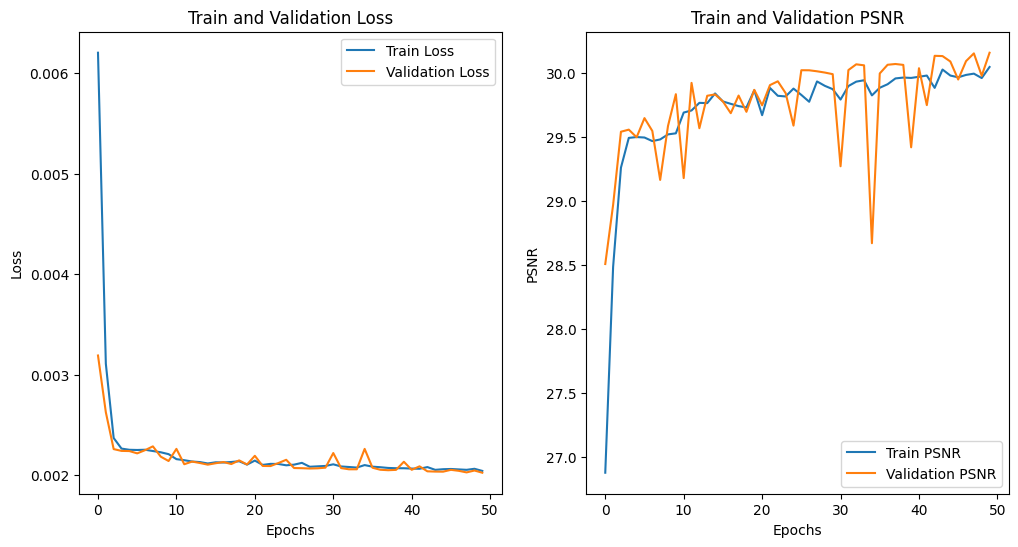

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot loss curves
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()

    # Plot PSNR curves
    plt.subplot(1, 2, 2)
    plt.plot(history.history['psnr_metric'], label='Train PSNR')
    plt.plot(history.history['val_psnr_metric'], label='Validation PSNR')
    plt.xlabel('Epochs')
    plt.ylabel('PSNR')
    plt.title('Train and Validation PSNR')
    plt.legend()

    plt.show()

# Call function to plot training history
plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


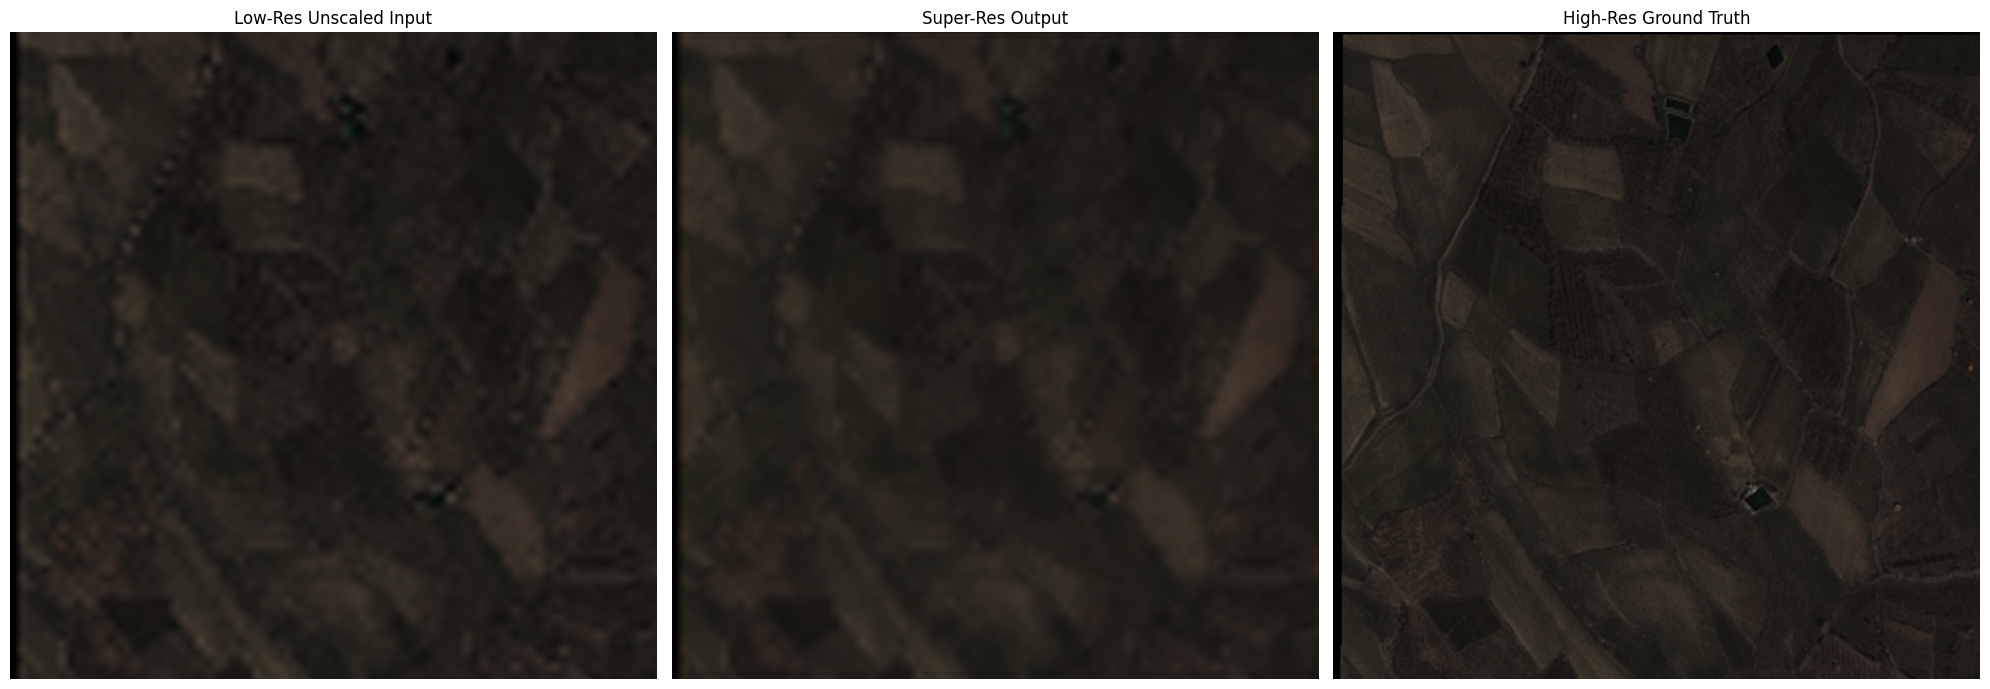

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to create low-resolution images from high-resolution images
def create_lr_image_tuple(hr_image, downscale_size=(160, 160), upscale_size=(1054, 1054), normalize=True):
    lr_image = cv2.resize(hr_image, downscale_size, interpolation=cv2.INTER_CUBIC)
    lr_image_unscaled = cv2.resize(lr_image, upscale_size, interpolation=cv2.INTER_CUBIC)
    if normalize:
        lr_image = np.clip(lr_image_unscaled / 255.0, 0, 1)  # Normalize to 0 to 1 and clip values
    return lr_image, lr_image_unscaled

# Paths to the high-resolution image
hr_image_path = '/content/drive/MyDrive/high_resolution_final/Landcover-101558_rgb.png'

# Load the high-resolution image
hr_image = load_image(hr_image_path, target_size=(1054, 1054), normalize=True)

# Create the low-resolution image
lr_image, lr_image_unscaled = create_lr_image_tuple(hr_image, downscale_size=(160, 160), upscale_size=(1054, 1054), normalize=True)

# Extract a 1/4 patch (527x527) from both HR and LR images
hr_patch = hr_image[0:527, 0:527]
lr_patch = lr_image[0:527, 0:527]
lr_patch_unscaled = lr_image_unscaled[0:527, 0:527]

# Predict the super-resolved image using the model
lr_patch_input = np.expand_dims(lr_patch, axis=0)
sr_patch = model.predict(lr_patch_input)
sr_patch = np.clip(np.squeeze(sr_patch, axis=0), 0, 1)

# Plot the results
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(lr_patch_unscaled)
plt.title('Low-Res Unscaled Input')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sr_patch)
plt.title('Super-Res Output')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(hr_patch)
plt.title('High-Res Ground Truth')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Function to calculate PSNR
def calculate_psnr(img1, img2):
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)
    return tf.image.psnr(img1, img2, max_val=1.0).numpy()

# Function to calculate SSIM
def calculate_ssim(img1, img2):
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)
    return tf.image.ssim(img1, img2, max_val=1.0).numpy()

# Calculate metrics
psnr_lr_hr = calculate_psnr(lr_patch, hr_patch)
ssim_lr_hr = calculate_ssim(lr_patch, hr_patch)
psnr_sr_hr = calculate_psnr(sr_patch, hr_patch)
ssim_sr_hr = calculate_ssim(sr_patch, hr_patch)

# Print metrics
print(f"PSNR between LR and HR: {psnr_lr_hr}")
print(f"SSIM between LR and HR: {ssim_lr_hr}")
print(f"PSNR between SR and HR: {psnr_sr_hr}")
print(f"SSIM between SR and HR: {ssim_sr_hr}")

PSNR between LR and HR: 17.817644119262695
SSIM between LR and HR: 0.013884020037949085
PSNR between SR and HR: 35.65992736816406
SSIM between SR and HR: 0.9055907130241394


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

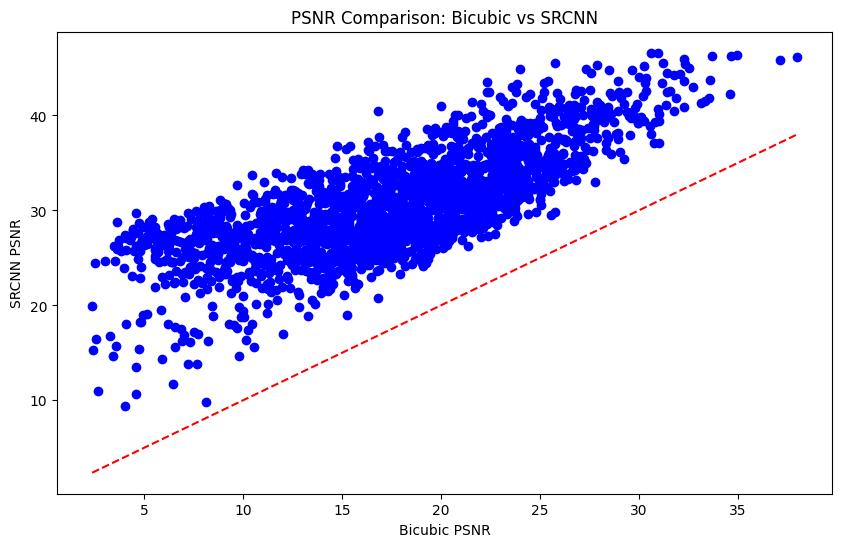

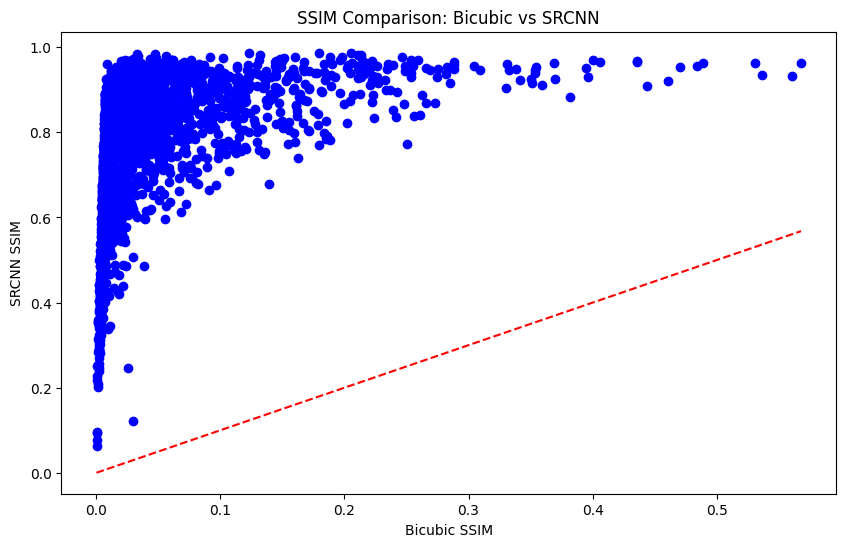

In [ ]:
# Load image filenames
hr_dir = '/content/drive/MyDrive/high_resolution_final'
hr_image_files = [f for f in os.listdir(hr_dir) if f.endswith('_rgb.png') and not f.startswith('.')]

# Lists to store PSNR and SSIM scores
bicubic_psnr_scores = []
srcnn_psnr_scores = []
bicubic_ssim_scores = []
srcnn_ssim_scores = []

# Iterate over the image files
for hr_image_file in hr_image_files:
    hr_image_path = os.path.join(hr_dir, hr_image_file)
    hr_image = load_image(hr_image_path)
    lr_image = create_lr_image(hr_image, downscale_size=(160, 160), upscale_size=(1054, 1054), normalize=True)

    # Extract a 1/4 patch (527x527) from both HR and LR images
    hr_patch = hr_image[0:527, 0:527]
    lr_patch = lr_image[0:527, 0:527]

    # Predict the super-resolved image using the model
    lr_patch_input = np.expand_dims(lr_patch, axis=0)
    sr_patch = model.predict(lr_patch_input)
    sr_patch = np.clip(np.squeeze(sr_patch, axis=0), 0, 1)

    # Ensure that the data types are correct
    lr_patch = lr_patch.astype(np.float32)
    hr_patch = hr_patch.astype(np.float32)
    sr_patch = sr_patch.astype(np.float32)

    # Calculate PSNR and SSIM scores
    psnr_bicubic = calculate_psnr(lr_patch, hr_patch)
    ssim_bicubic = calculate_ssim(lr_patch, hr_patch)
    psnr_srcnn = calculate_psnr(sr_patch, hr_patch)
    ssim_srcnn = calculate_ssim(sr_patch, hr_patch)

    # Append scores to lists
    bicubic_psnr_scores.append(psnr_bicubic)
    srcnn_psnr_scores.append(psnr_srcnn)
    bicubic_ssim_scores.append(ssim_bicubic)
    srcnn_ssim_scores.append(ssim_srcnn)

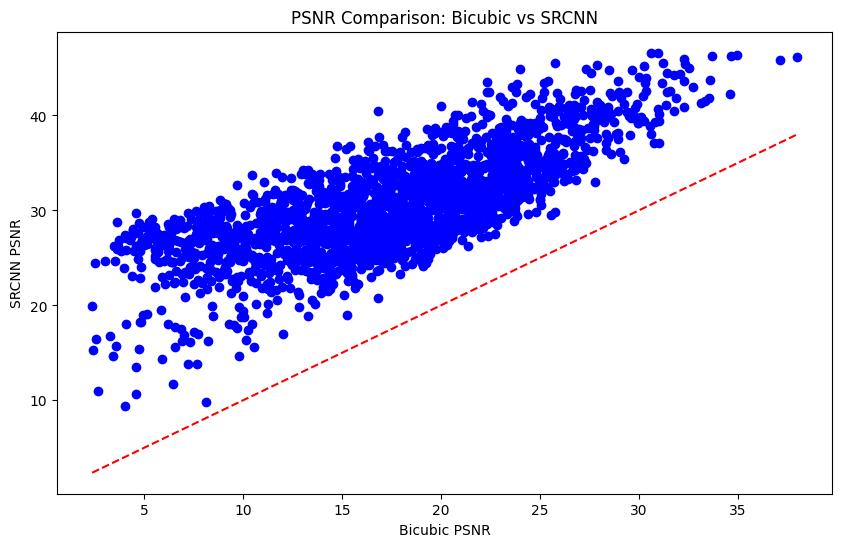

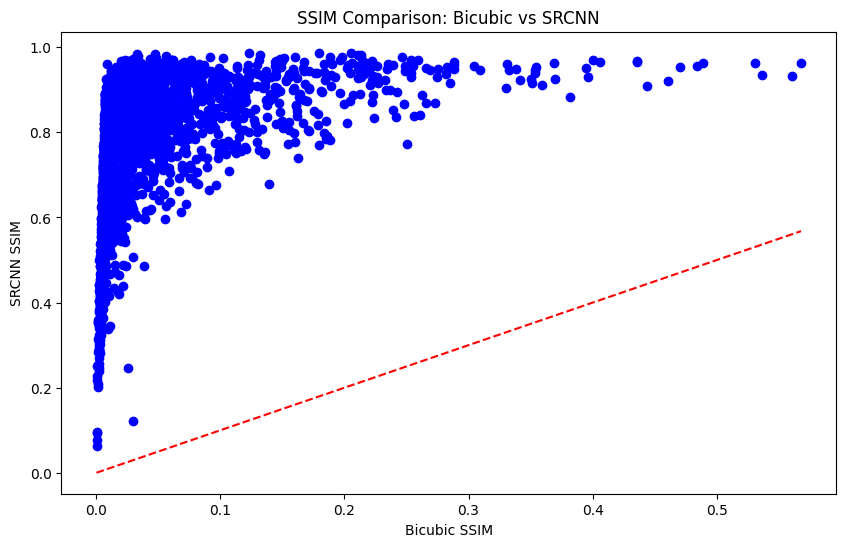

In [ ]:
# Plot PSNR comparison
plt.figure(figsize=(10, 6))
plt.scatter(bicubic_psnr_scores, srcnn_psnr_scores, color='blue')
plt.plot([min(bicubic_psnr_scores), max(bicubic_psnr_scores)], [min(bicubic_psnr_scores), max(bicubic_psnr_scores)], 'r--')
plt.xlabel('Bicubic PSNR')
plt.ylabel('SRCNN PSNR')
plt.title('PSNR Comparison: Bicubic vs SRCNN')
plt.show()

# Plot SSIM comparison
plt.figure(figsize=(10, 6))
plt.scatter(bicubic_ssim_scores, srcnn_ssim_scores, color='blue')
plt.plot([min(bicubic_ssim_scores), max(bicubic_ssim_scores)], [min(bicubic_ssim_scores), max(bicubic_ssim_scores)], 'r--')
plt.xlabel('Bicubic SSIM')
plt.ylabel('SRCNN SSIM')
plt.title('SSIM Comparison: Bicubic vs SRCNN')
plt.show()